In [1]:
from rockit import *
from casadi import SX, MX, vertcat, cross, fabs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from pyquaternion import Quaternion

In [2]:
ocp = Ocp(t0=0, T=FreeTime(100))

In [3]:
Tmax = 0.000953
Wmax = 1570.79632679
Vmax = 6
a_1 = np.array([[1],[0],[0]])
a_2 = np.array([[0],[1],[0]])
a_3 = np.array([[0],[0],[1]])
a_mat = np.concatenate((a_1, a_2, a_3), axis=1)
I = np.array([[0.04, 0.00, 0.00],
              [0.00, 0.05, 0.02],
              [0.00, 0.02, 0.05]])
I_inv = np.linalg.inv(I)
I_rw = 6.25E-05
I_wheels = I_rw*(a_1*np.transpose(a_1) + a_2*np.transpose(a_2) + a_3*np.transpose(a_3))

In [4]:
q = ocp.state(4)
w = ocp.state(3)
Omega = ocp.state(3)
V = ocp.control(3)
# Q = ocp.algebraic(4, 4)
# Q[0,0] = 0
# Q[0,1] = -w[0]
# Q[0,2] = -w[1]
# Q[0,3] = -w[2]

# Q[1,0] = w[0]
# Q[1,1] = 0
# Q[1,2] = -w[2]
# Q[1,3] = w[1]

# Q[2,0] = w[1]
# Q[2,1] = w[2]
# Q[2,2] = 0
# Q[2,3] = w[0]

# Q[3,0] = w[2]
# Q[3,1] = -w[1]
# Q[3,2] = w[0]
# Q[3,3] = 0

In [5]:
# Assign derivatives

ocp.set_der(q, vertcat(
    -w[0]*q[1]-w[1]*q[2]-w[2]*q[3],
    w[0]*q[0] +w[1]*q[3]-w[2]*q[2],
    -w[0]*q[3]+w[1]*q[0]+w[2]*q[1],
    w[0]*q[2] -w[1]*q[1]+w[2]*q[0]
))
# ocp.set_der(q[0], -w[0]*q[1]-w[1]*q[2]-w[2]*q[3])
ocp.set_der(w, -(Tmax/Vmax)*a_mat@V + (Tmax/Wmax)*a_mat@Omega - cross(w, (I@w) + (I_wheels@w) + I_rw*(a_mat@Omega)))
ocp.set_der(Omega, (Tmax/(Vmax*I_rw))*V - (Tmax/(Wmax*I_rw))*Omega - a_mat.T@w)

In [6]:
# Constraints

ocp.subject_to(q[0]**2 + q[1]**2 + q[2]**2 + q[3]**2 == 1)
ocp.subject_to(-6 <= (V[0] <= 6))
ocp.subject_to(-6 <= (V[1] <= 6))
ocp.subject_to(-6 <= (V[2] <= 6))

In [7]:
# Boundary conditions

ocp.subject_to(ocp.at_t0(q) == np.array([1,0.0,0.0,0.0]))
ocp.subject_to(ocp.at_tf(q) == np.array([-0.0434363, -0.5855824, -0.7539713, -0.2945059]))
# ocp.subject_to(ocp.at_tf(q) == np.array([-4.34362998e-02, -5.85582404e-01, -7.53971357e-01, -2.94505902e-01]))

ocp.subject_to(ocp.at_t0(w) == np.array([0,0.0,0.0]))
ocp.subject_to(ocp.at_tf(w) == np.array([0,0.0,0.0]))

ocp.subject_to(ocp.at_t0(Omega) == np.array([0,0.0,0.0]))
ocp.subject_to(ocp.at_tf(Omega) == np.array([0,0.0,0.0]))

In [8]:
ocp.add_objective(ocp.T)

In [9]:
# ocp.solver('ipopt', {"ipopt": {"max_iter": 3000}})
ocp.solver('ipopt', {"ipopt": {"max_iter": 2500}})

method = MultipleShooting(N=200, intg='rk')
ocp.method(method)

In [10]:
sol = ocp.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    26024
Number of nonzeros in inequality constraint Jacobian.:      604
Number of nonzeros in Lagrangian Hessian.............:    19605

Total number of variables............................:     2611
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2221
Total number of inequality c

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80r 1.9888850e+02 1.88e+00 1.21e+03  -8.6 9.08e+01    -  7.89e-04 1.73e-03h  1
  81r 1.9919090e+02 1.87e+00 1.90e+03  -8.6 9.09e+01    -  9.95e-04 3.32e-03h  1
  82r 1.9933020e+02 1.87e+00 1.76e+03  -8.6 9.12e+01    -  5.58e-03 1.53e-03h  1
  83r 2.0005064e+02 1.85e+00 2.04e+03  -8.6 9.12e+01    -  1.14e-03 7.90e-03h  1
  84r 2.0019093e+02 1.85e+00 2.03e+03  -8.6 9.15e+01    -  3.22e-03 1.53e-03h  1
  85r 2.0040858e+02 1.84e+00 2.12e+03  -8.6 9.15e+01    -  1.66e-02 2.38e-03h  1
  86r 2.0206829e+02 1.81e+00 1.99e+03  -8.6 9.16e+01    -  3.27e-03 1.81e-02h  1
  87r 2.0244947e+02 1.80e+00 1.98e+03  -8.6 9.22e+01    -  2.54e-02 4.14e-03h  1
  88r 2.0492244e+02 1.75e+00 1.93e+03  -8.6 9.23e+01    -  2.52e-03 2.68e-02h  1
  89r 2.0779343e+02 1.70e+00 1.87e+03  -8.6 9.31e+01    -  1.30e-02 3.08e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90r 2.0879839e+02 1.68e+00

 174r 4.5207393e+02 1.37e-01 1.62e+03  -8.6 2.23e+01    -  5.29e-03 8.58e-03h  1
 175r 4.5242148e+02 1.35e-01 1.60e+03  -8.6 2.20e+01    -  2.05e-03 1.58e-02f  1
 176r 4.5302840e+02 1.31e-01 1.55e+03  -8.6 2.17e+01    -  4.01e-03 2.80e-02f  1
 177r 4.5313175e+02 1.31e-01 1.54e+03  -8.6 2.11e+01    -  9.65e-03 4.90e-03f  1
 178r 4.5326604e+02 1.30e-01 1.53e+03  -8.6 2.10e+01    -  5.69e-03 6.40e-03h  1
 179r 4.5336350e+02 1.29e-01 1.53e+03  -8.6 2.08e+01    -  5.43e-03 4.69e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180r 4.5346121e+02 1.28e-01 1.52e+03  -8.6 2.07e+01    -  3.58e-03 4.72e-03h  1
 181r 4.5356555e+02 1.28e-01 1.51e+03  -8.6 2.06e+01    -  6.96e-03 5.07e-03h  1
 182r 4.5362342e+02 1.27e-01 1.51e+03  -8.6 2.05e+01    -  3.08e-03 2.82e-03h  1
 183r 4.5373511e+02 1.27e-01 1.50e+03  -8.6 2.04e+01    -  1.30e-03 5.48e-03h  1
 184r 4.5380059e+02 1.26e-01 1.49e+03  -8.6 2.02e+01    -  6.25e-03 3.23e-03h  1
 185r 4.5383594e+02 1.26e-01

 269r 4.6587427e+02 4.07e-02 4.05e+03  -8.6 4.95e+00  -4.0 6.39e-02 7.21e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270r 4.6587576e+02 4.07e-02 4.05e+03  -8.6 1.35e+01  -4.5 9.61e-03 1.10e-04h  1
 271r 4.6652048e+02 3.60e-02 3.80e+03  -8.6 5.37e+00  -4.1 3.26e-01 1.20e-01f  1
 272r 4.6652230e+02 3.60e-02 3.90e+03  -8.6 2.76e+01  -4.6 9.36e-04 6.56e-05h  1
 273r 4.6739735e+02 3.08e-02 3.30e+03  -8.6 5.62e+00  -4.1 4.61e-02 1.56e-01h  1
 274r 4.6740605e+02 3.07e-02 3.64e+03  -8.6 1.89e+01  -4.6 1.77e-03 4.61e-04h  1
 275r 4.6772444e+02 2.91e-02 3.42e+03  -8.6 5.90e+00  -4.2 7.88e-02 5.39e-02h  1
 276r 4.6773102e+02 2.91e-02 3.49e+03  -8.6 2.62e+00  -3.8 1.87e-01 2.52e-03h  1
 277r 4.6885017e+02 2.47e-02 2.89e+03  -8.6 6.45e+00  -4.2 3.25e-01 1.73e-01h  1
 278r 4.6885368e+02 2.47e-02 2.88e+03  -8.6 2.74e+00  -3.8 6.97e-01 1.28e-03h  1
 279r 4.6907966e+02 2.40e-02 2.84e+03  -8.6 7.29e+00  -4.3 6.18e-02 3.10e-02h  1
iter    objective    inf_pr 

 365r 5.2803706e+01 2.20e-01 9.06e+02  -1.7 1.97e+02    -  8.98e-02 7.81e-02f  1
 366r 8.1411849e+01 1.73e+00 7.32e+02  -1.7 1.49e+02    -  1.92e-01 1.92e-01f  1
 367r 1.0880587e+02 1.75e+00 6.08e+02  -1.7 1.38e+02    -  1.54e-01 1.99e-01f  1
 368r 1.7724616e+02 1.88e+00 5.43e+02  -1.7 1.02e+02    -  2.87e-01 5.64e-01H  1
 369r 1.9418184e+02 1.13e+00 1.85e+02  -1.7 4.80e+01    -  8.07e-01 3.53e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 370r 2.0308095e+02 2.94e-01 3.33e+01  -1.7 1.42e+01    -  7.55e-01 8.18e-01h  1
 371r 2.0940288e+02 6.01e-02 3.53e+01  -1.7 1.09e+01    -  1.00e+00 8.93e-01f  1
 372r 2.1193133e+02 9.81e-04 1.16e+00  -1.7 2.53e+00    -  1.00e+00 1.00e+00h  1
 373  2.1193133e+00 6.00e+00 1.13e+00  -1.7 4.88e+04    -  1.35e-02 4.30e-03f  1
 374  3.2243987e+00 5.93e+00 6.24e+00  -1.7 1.04e+02    -  2.19e-02 1.06e-02h  5
 375  3.9481326e+00 5.89e+00 8.25e+00  -1.7 1.91e+02    -  5.39e-02 6.92e-03h  4
 376r 3.9481326e+00 5.89e+00

 466r 6.7826271e+01 3.08e-04 4.68e+02  -5.5 6.76e+00    -  1.01e-02 3.33e-02h  1
 467r 6.7851352e+01 2.74e-04 3.86e+02  -5.5 6.17e+00    -  4.02e-01 1.74e-01h  1
 468r 6.7879056e+01 3.04e-04 3.51e+02  -5.5 1.06e+01    -  8.62e-02 9.05e-02h  1
 469r 6.7898488e+01 3.24e-04 3.35e+02  -5.5 1.43e+01    -  1.83e-01 4.75e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 470r 6.8042463e+01 1.48e-03 2.82e+02  -5.5 3.11e+01    -  3.27e-02 2.08e-01h  1
 471r 6.8126235e+01 1.66e-03 2.54e+02  -5.5 3.36e+01    -  1.19e-01 1.03e-01h  1
 472r 6.8260061e+01 2.04e-03 2.25e+02  -5.5 4.48e+01    -  9.20e-02 1.12e-01h  1
 473r 6.8299337e+01 2.02e-03 2.20e+02  -5.5 4.77e+01    -  7.74e-02 2.72e-02h  1
 474r 6.8466018e+01 2.34e-03 2.01e+02  -5.5 6.02e+01    -  5.78e-02 8.68e-02h  1
 475r 6.8474544e+01 2.33e-03 2.00e+02  -5.5 5.42e+01    -  4.61e-02 4.44e-03h  1
 476r 6.8659475e+01 2.61e-03 1.85e+02  -5.5 6.94e+01    -  1.12e-02 7.47e-02h  1
 477r 6.8662482e+01 2.60e-03

 565r 8.3297304e+01 8.05e-03 3.89e+02  -5.5 3.04e+04  -7.8 5.59e-05 1.51e-07h  2
 566r 8.3489067e+01 8.10e-03 4.25e+02  -5.5 6.84e+02    -  3.62e-03 2.33e-03h  1
 567r 8.3587759e+01 8.10e-03 4.31e+02  -5.5 3.49e+02  -7.4 2.94e-04 2.33e-03h  1
 568r 8.3798906e+01 7.95e-03 4.29e+02  -5.5 4.81e+01  -7.0 3.16e-02 2.83e-02h  1
 569r 8.3840593e+01 7.94e-03 4.31e+02  -5.5 2.40e+02  -7.4 2.16e-03 1.33e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 570r 8.4169427e+01 8.11e-03 4.60e+02  -5.5 1.83e+03  -7.9 2.34e-03 1.55e-03h  1
 571r 8.4280501e+01 8.11e-03 4.61e+02  -5.5 7.83e+02  -7.5 1.18e-04 1.21e-03h  1
 572r 8.4853165e+01 8.21e-03 3.79e+02  -5.5 5.59e+01  -7.1 3.43e-02 5.87e-02h  1
 573r 8.4866198e+01 8.21e-03 3.82e+02  -5.5 5.68e+02  -7.5 9.24e-04 1.91e-04h  1
 574r 8.5243815e+01 8.20e-03 3.81e+02  -5.5 9.00e+01  -7.1 5.05e-02 2.77e-02h  1
 575r 8.5365641e+01 8.23e-03 3.78e+02  -5.5 6.86e+03  -7.6 2.19e-05 1.57e-04h  1
 576r 8.5413730e+01 8.23e-03

 663r 1.0936943e+02 5.72e-03 1.25e+02  -5.5 6.47e+01    -  1.19e-03 8.64e-03h  1
 664r 1.0939230e+02 5.51e-03 1.27e+02  -5.5 2.26e+01    -  6.25e-02 3.60e-02h  1
 665r 1.0943744e+02 5.47e-03 1.23e+02  -5.5 6.46e+01    -  1.17e-03 8.09e-03h  1
 666r 1.0946241e+02 5.28e-03 1.26e+02  -5.5 2.21e+01    -  6.11e-02 3.50e-02h  1
 667r 1.0950960e+02 5.24e-03 1.22e+02  -5.5 6.45e+01    -  1.16e-03 7.62e-03h  1
 668r 1.0953622e+02 5.06e-03 1.24e+02  -5.5 2.15e+01    -  6.00e-02 3.43e-02h  1
 669r 1.0958524e+02 5.03e-03 1.20e+02  -5.5 6.43e+01    -  1.15e-03 7.23e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 670r 1.0961342e+02 4.85e-03 1.24e+02  -5.5 2.08e+01    -  5.95e-02 3.40e-02h  1
 671r 1.0966410e+02 4.83e-03 1.24e+02  -5.5 6.41e+01    -  1.15e-03 6.89e-03h  1
 672r 1.0969394e+02 4.66e-03 1.28e+02  -5.5 2.01e+01    -  5.94e-02 3.39e-02h  1
 673r 1.0974625e+02 4.63e-03 1.28e+02  -5.5 6.37e+01    -  1.16e-03 6.59e-03h  1
 674r 1.0977769e+02 4.47e-03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 760r 1.1057811e+02 3.78e-02 8.84e+02  -8.2 8.96e+01  -7.1 9.44e-04 4.01e-03h  1
 761r 1.1057800e+02 3.77e-02 8.78e+02  -8.2 3.40e+01  -6.7 3.89e-02 1.63e-03h  1
 762r 1.1061455e+02 3.75e-02 8.73e+02  -8.2 1.03e+02  -7.2 1.77e-03 6.38e-03h  1
 763r 1.1061535e+02 3.72e-02 8.65e+02  -8.2 3.69e+01  -6.7 1.74e-02 7.69e-03h  1
 764r 1.1061478e+02 3.70e-02 8.61e+02  -8.2 1.24e+01  -6.3 3.53e-03 4.77e-03h  1
 765r 1.1061573e+02 3.70e-02 8.88e+02  -8.2 3.50e+01  -6.8 2.13e-02 1.51e-03f  1
 766r 1.1061284e+02 3.58e-02 8.31e+02  -8.2 1.41e+01  -6.4 1.91e-02 3.16e-02h  1
 767r 1.1062273e+02 3.51e-02 8.15e+02  -8.2 4.65e+01  -6.8 9.02e-03 1.99e-02h  1
 768r 1.1066766e+02 3.50e-02 8.13e+02  -8.2 1.89e+02  -7.3 5.09e-03 2.32e-03h  1
 769r 1.1066939e+02 3.49e-02 8.40e+02  -8.2 4.98e+01  -6.9 1.83e-02 1.70e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 770r 1.1075988e+02 3.49e-02

 857r 1.1307395e+02 1.44e-02 8.95e+02  -8.2 2.71e+01  -6.4 1.68e-02 4.19e-03h  1
 858r 1.1308931e+02 1.44e-02 8.94e+02  -8.2 1.27e+02  -6.9 3.03e-03 1.38e-03h  1
 859r 1.1309018e+02 1.44e-02 8.93e+02  -8.2 3.44e+01  -6.5 4.48e-03 2.95e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 860r 1.1309971e+02 1.41e-02 8.80e+02  -8.2 1.12e+01  -6.0 5.10e-03 1.49e-02f  1
 861r 1.1310909e+02 1.41e-02 8.76e+02  -8.2 3.59e+01  -6.5 9.57e-03 3.97e-03f  1
 862r 1.1312270e+02 1.41e-02 8.76e+02  -8.2 1.80e+02  -7.0 6.42e-04 1.00e-03h  1
 863r 1.1319398e+02 1.37e-02 8.93e+02  -8.2 4.15e+01  -6.6 1.07e-03 2.55e-02h  1
 864r 1.1319803e+02 1.37e-02 8.50e+02  -8.2 1.46e+01  -6.2 1.84e-02 4.13e-03h  1
 865r 1.1320672e+02 1.36e-02 8.48e+02  -8.2 4.78e+01  -6.6 4.99e-03 2.22e-03h  1
 866r 1.1324727e+02 1.36e-02 8.46e+02  -8.2 2.78e+02  -7.1 4.16e-03 2.08e-03h  1
 867r 1.1326282e+02 1.35e-02 8.43e+02  -8.2 5.62e+01  -6.7 1.64e-03 3.79e-03h  1
 868r 1.1327307e+02 1.35e-02

 952r 1.1637146e+02 9.45e-03 1.31e+03  -8.2 3.00e+01  -6.6 1.08e-02 1.29e-03h  1
 953r 1.1638082e+02 9.44e-03 1.31e+03  -8.2 1.13e+02  -7.1 1.73e-03 1.22e-03h  1
 954r 1.1638153e+02 9.44e-03 1.31e+03  -8.2 3.33e+01  -6.6 7.27e-03 4.30e-04h  1
 955r 1.1642621e+02 9.39e-03 1.30e+03  -8.2 1.28e+02  -7.1 5.88e-04 6.01e-03h  1
 956r 1.1646011e+02 9.23e-03 1.28e+03  -8.2 3.77e+01  -6.7 1.82e-02 1.78e-02f  1
 957r 1.1696503e+02 9.99e-03 1.25e+03  -8.2 2.08e+02  -7.2 1.30e-03 2.73e-02f  1
 958r 1.1696502e+02 9.99e-03 1.25e+03  -8.2 6.43e+01  -5.8 8.57e-03 5.35e-05h  1
 959r 1.1696833e+02 9.93e-03 1.24e+03  -8.2 1.28e+01  -6.3 1.65e-01 5.12e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 960r 1.1699196e+02 9.57e-03 1.19e+03  -8.2 8.58e+00  -6.8 9.10e-02 3.65e-02h  1
 961r 1.1707142e+02 9.31e-03 1.16e+03  -8.2 1.57e+01  -7.3 6.88e-02 2.64e-02h  1
 962r 1.1711886e+02 8.58e-03 1.07e+03  -8.2 9.65e+00  -6.9 1.62e-01 7.81e-02h  1
 963r 1.1749752e+02 7.36e-03

1051r 1.2640319e+02 2.26e-03 8.28e+02  -8.2 3.36e+02  -8.7 3.61e-03 3.26e-03h  1
1052r 1.2648269e+02 2.20e-03 8.69e+02  -8.2 1.57e+01  -8.3 3.10e-02 2.38e-02h  1
1053r 1.2665102e+02 2.20e-03 8.56e+02  -8.2 4.70e+01  -8.7 1.26e-02 1.43e-02f  1
1054r 1.2676341e+02 2.16e-03 9.26e+02  -8.2 2.22e+01  -8.3 8.58e-03 2.30e-02h  1
1055r 1.2695362e+02 2.20e-03 9.29e+02  -8.2 5.80e+02  -8.8 8.96e-04 1.49e-03h  1
1056r 1.2713643e+02 2.15e-03 9.98e+02  -8.2 2.24e+01  -8.4 2.81e-02 3.87e-02h  1
1057r 1.2715681e+02 2.15e-03 8.05e+02  -8.2 1.64e+02  -8.8 4.40e-03 5.42e-04h  1
1058r 1.2736837e+02 2.21e-03 8.03e+02  -8.2 3.86e+02  -9.3 2.72e-03 2.47e-03f  1
1059r 1.2750294e+02 2.22e-03 8.20e+02  -8.2 8.89e+01  -8.9 2.65e-03 7.10e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1060r 1.2769399e+02 2.14e-03 8.00e+02  -8.2 1.86e+01  -8.5 2.44e-02 5.19e-02h  1
1061r 1.2776522e+02 2.08e-03 7.49e+02  -8.2 1.40e+01  -8.0 4.24e-02 2.79e-02h  1
1062r 1.2806504e+02 2.12e-03

1145r 1.3547657e+02 7.15e-04 3.59e+02  -8.2 3.49e+00  -7.5 3.01e-02 4.50e-02h  1
1146r 1.3553313e+02 7.21e-04 3.54e+02  -8.2 2.35e+01  -7.9 1.64e-02 1.18e-02f  1
1147r 1.3557483e+02 6.64e-04 3.76e+02  -8.2 3.67e+00  -7.5 7.26e-02 9.64e-02f  1
1148r 1.3558844e+02 6.31e-04 4.86e+02  -8.2 1.91e+00  -7.1 1.95e-01 5.08e-02f  1
1149r 1.3564057e+02 5.91e-04 4.11e+02  -8.2 4.15e+00  -7.6 7.69e-02 8.64e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1150r 1.3564409e+02 5.91e-04 6.00e+02  -8.2 1.36e+03  -8.0 5.37e-04 1.46e-05h  7
1151r 1.3566915e+02 5.75e-04 5.17e+02  -8.2 4.93e+00  -7.6 1.05e-01 3.21e-02h  1
1152r 1.3571769e+02 4.93e-04 5.20e+02  -8.2 2.40e+00  -7.2 2.32e-01 1.56e-01f  1
1153r 1.3574059e+02 4.77e-04 6.62e+02  -8.2 5.18e+00  -7.7 7.23e-02 3.69e-02h  1
1154r 1.3578849e+02 4.18e-04 4.89e+02  -8.2 2.59e+00  -7.2 1.10e-01 1.38e-01f  1
1155r 1.3584407e+02 4.01e-04 4.43e+02  -8.2 5.46e+00  -7.7 1.01e-01 7.10e-02f  1
1156r 1.3591486e+02 3.35e-04

1241  1.3978847e+02 2.18e-05 2.39e-01  -5.7 8.60e-01  -2.1 1.00e+00 1.17e-02f  5
1242  1.3866544e+02 7.55e-06 4.86e-01  -5.7 1.90e+00  -2.6 1.00e+00 1.00e+00F  1
1243  1.3858080e+02 3.40e-05 4.74e-01  -5.7 4.67e+00  -3.1 1.00e+00 2.44e-02f  3
1244  1.3807967e+02 1.47e-03 4.47e-01  -5.7 1.26e+01  -3.5 1.00e+00 5.41e-02f  1
1245  1.3624803e+02 2.02e-02 3.91e-01  -5.7 2.90e+01  -4.0 1.00e+00 8.78e-02f  1
1246  1.3395344e+02 4.65e-02 3.49e-01  -5.7 5.76e+01  -4.5 1.00e+00 6.31e-02f  1
1247  1.3250934e+02 6.03e-02 5.72e-01  -5.7 2.51e+02  -5.0 1.26e-01 2.37e-02f  1
1248  1.3081893e+02 5.74e-02 7.30e-01  -5.7 5.97e+01  -4.5 1.00e+00 4.74e-02f  1
1249  1.2995402e+02 5.65e-02 1.03e+00  -5.7 2.87e+02  -5.0 7.05e-02 1.44e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1250  1.2789904e+02 5.64e-02 1.30e+00  -5.7 6.06e+01  -4.6 1.00e+00 5.77e-02f  1
1251  1.2707281e+02 5.58e-02 1.73e+00  -5.7 3.51e+02  -5.1 6.27e-03 1.38e-02f  1
1252  1.2625713e+02 5.74e-02

1338  8.0166615e+01 5.00e-02 2.74e+00  -5.7 2.68e+01  -5.0 1.47e-02 2.41e-02h  1
1339  8.0039507e+01 4.89e-02 2.69e+00  -5.7 1.07e+02  -5.5 3.18e-02 2.18e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1340  8.0003045e+01 4.82e-02 2.65e+00  -5.7 4.52e+01  -5.1 6.90e-02 1.39e-02h  1
1341  7.9941555e+01 4.74e-02 2.60e+00  -5.7 1.07e+02  -5.6 1.07e-02 1.74e-02h  1
1342  7.9588090e+01 4.14e-02 2.30e+00  -5.7 4.96e+01  -5.1 2.15e-01 1.26e-01f  1
1343  7.9563141e+01 4.13e-02 2.29e+00  -5.7 1.17e+02  -5.6 2.97e-02 4.14e-03h  1
1344  7.9210864e+01 3.61e-02 2.02e+00  -5.7 5.33e+01  -5.2 1.29e-01 1.25e-01h  1
1345  7.8990277e+01 3.87e-02 1.96e+00  -5.7 1.33e+02  -5.7 1.90e-02 3.76e-02h  1
1346  7.8975975e+01 3.84e-02 1.94e+00  -5.7 2.94e+01  -5.2 1.20e-02 8.05e-03h  1
1347  7.8961660e+01 3.83e-02 1.94e+00  -5.7 1.44e+02  -5.7 8.34e-02 2.54e-03h  1
1348  7.8868067e+01 3.64e-02 1.84e+00  -5.7 5.13e+01  -5.3 7.87e-03 4.92e-02h  1
1349  7.8723342e+01 3.55e-02

1433  7.7809970e+01 6.00e-03 5.51e+00  -5.7 5.84e+01  -5.2 6.88e-02 0.00e+00S 12
1434  7.7817271e+01 5.98e-03 5.50e+00  -5.7 2.41e+02  -5.7 1.11e-02 2.62e-03h  1
1435  7.7857821e+01 5.58e-03 5.12e+00  -5.7 6.91e+01  -5.3 1.55e-02 6.89e-02h  1
1436  7.7868293e+01 5.56e-03 5.11e+00  -5.7 2.89e+02  -5.7 1.23e-02 2.32e-03h  5
1437  7.7894459e+01 5.37e-03 4.94e+00  -5.7 7.53e+01  -5.3 1.11e-01 3.46e-02h  1
1438  7.7901216e+01 5.37e-03 4.93e+00  -5.7 3.80e+02  -5.8 9.17e-03 1.10e-03h  6
1439  7.7949599e+01 5.09e-03 4.67e+00  -5.7 8.94e+01  -5.4 7.91e-03 5.25e-02h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1440  7.7957948e+01 5.08e-03 4.67e+00  -5.7 4.94e+02  -5.8 6.16e-03 9.65e-04h  5
1441  7.7994908e+01 4.92e-03 4.52e+00  -5.7 1.04e+02  -5.4 1.02e-01 3.27e-02h  2
1442  7.7999714e+01 4.92e-03 4.52e+00  -5.7 6.72e+02  -5.9 1.16e-02 3.75e-04h  5
1443  7.8042929e+01 5.37e-03 4.38e+00  -5.7 1.18e+02  -5.5 2.09e-02 3.11e-02H  1
1444  7.8047414e+01 5.38e-03

1533  7.7272844e+01 1.88e-02 9.25e-01  -5.7 1.12e+03    -  1.51e-03 2.27e-03f  1
1534  7.7272016e+01 1.88e-02 9.25e-01  -5.7 1.45e+03    -  1.88e-03 4.13e-05h  1
1535  7.7236638e+01 1.88e-02 9.24e-01  -5.7 4.92e+02    -  2.35e-03 2.09e-03f  1
1536  7.7096980e+01 2.20e-02 9.17e-01  -5.7 1.28e+03    -  2.78e-03 6.92e-03f  1
1537  7.7066969e+01 2.04e-02 9.15e-01  -5.7 4.66e+03    -  6.97e-04 1.92e-03f  1
1538  7.7051757e+01 2.05e-02 9.15e-01  -5.7 1.07e+03    -  1.52e-02 1.02e-03f  1
1539  7.7031608e+01 2.02e-02 9.13e-01  -5.7 1.79e+03    -  8.20e-03 1.60e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1540  7.7010944e+01 2.03e-02 9.09e-01  -5.7 1.64e+03    -  3.37e-03 4.04e-03h  1
1541  7.6978216e+01 2.11e-02 9.05e-01  -5.7 1.96e+03    -  1.92e-03 4.42e-03h  1
1542  7.6917335e+01 2.10e-02 9.02e-01  -5.7 1.31e+03    -  3.47e-03 3.54e-03f  1
1543  7.6842836e+01 2.11e-02 8.99e-01  -5.7 1.46e+03    -  7.09e-04 3.40e-03f  1
1544  7.6828865e+01 2.02e-02

1629  7.4181697e+01 2.49e-02 6.76e-01  -5.7 5.19e+02    -  1.14e-02 2.25e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1630  7.4156146e+01 2.48e-02 6.75e-01  -5.7 4.13e+03    -  7.96e-04 8.15e-04f  1
1631  7.4136029e+01 2.47e-02 6.71e-01  -5.7 3.45e+02    -  5.30e-03 7.20e-03h  1
1632  7.4112286e+01 2.46e-02 6.69e-01  -5.7 1.43e+03    -  4.48e-03 2.15e-03f  1
1633  7.4111230e+01 2.45e-02 6.66e-01  -5.7 5.87e+01    -  4.34e-03 4.73e-03h  1
1634  7.4077606e+01 2.44e-02 6.64e-01  -5.7 1.68e+03    -  1.39e-04 2.68e-03f  1
1635  7.4026298e+01 2.43e-02 6.62e-01  -5.7 1.79e+03    -  3.12e-03 3.80e-03f  1
1636  7.4020952e+01 2.43e-02 6.61e-01  -5.7 3.83e+02    -  5.09e-03 1.70e-03h  1
1637  7.4019548e+01 2.42e-02 6.58e-01  -5.7 8.99e+01    -  4.59e-03 4.51e-03f  1
1638  7.3930174e+01 2.40e-02 6.53e-01  -5.7 1.87e+03    -  9.05e-04 6.38e-03f  1
1639  7.3928642e+01 2.39e-02 6.50e-01  -5.7 9.11e+01    -  4.81e-03 4.79e-03h  1
iter    objective    inf_pr 

1729  7.2867869e+01 5.29e-03 1.90e-01  -5.7 2.98e+01  -5.7 3.98e-02 1.26e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1730  7.2880815e+01 5.37e-03 1.89e-01  -5.7 1.44e+02  -6.2 1.18e-02 5.95e-03h  3
1731  7.2937651e+01 6.31e-03 1.88e-01  -5.7 3.97e+01  -5.8 1.07e-01 7.60e-02h  1
1732  7.2947215e+01 6.36e-03 1.87e-01  -5.7 1.92e+02  -6.2 3.41e-02 3.25e-03h  1
1733  7.2949955e+01 6.36e-03 1.87e-01  -5.7 1.02e+03  -6.7 2.24e-04 2.18e-04h  6
1734  7.2959086e+01 6.34e-03 1.87e-01  -5.7 2.75e+02  -6.3 5.79e-03 2.51e-03h  4
1735  7.2999602e+01 6.43e-03 1.85e-01  -5.7 5.59e+01  -5.9 1.71e-02 3.83e-02h  2
1736  7.3004207e+01 6.43e-03 1.85e-01  -5.7 4.26e+02  -6.3 8.22e-03 8.93e-04h  5
1737  7.3042301e+01 6.42e-03 1.84e-01  -5.7 6.62e+01  -5.9 4.20e-02 3.00e-02h  2
1738  7.3046497e+01 6.41e-03 1.84e-01  -5.7 7.75e+02  -6.4 6.04e-03 5.18e-04h  5
1739  7.3072007e+01 6.33e-03 1.82e-01  -5.7 7.77e+01  -6.0 2.17e-02 1.69e-02h  3
iter    objective    inf_pr 

1825  7.2239002e+01 1.31e-02 7.54e-01  -5.7 2.42e+01    -  1.92e-02 1.00e-02h  1
1826  7.2221955e+01 1.31e-02 7.53e-01  -5.7 1.75e+03    -  7.42e-04 2.11e-03f  1
1827  7.2217005e+01 1.28e-02 7.39e-01  -5.7 6.56e+02    -  4.16e-03 1.78e-02h  1
1828  7.2216012e+01 1.28e-02 7.35e-01  -5.7 4.87e+02    -  9.71e-03 5.15e-03h  1
1829  7.2212099e+01 1.26e-02 7.25e-01  -5.7 2.54e+02    -  3.62e-03 1.37e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1830  7.2168480e+01 1.24e-02 7.13e-01  -5.7 2.35e+02    -  3.56e-02 1.67e-02f  1
1831  7.2102118e+01 1.21e-02 6.94e-01  -5.7 2.53e+02  -6.7 2.69e-02 2.70e-02f  1
1832  7.2057602e+01 1.18e-02 6.80e-01  -5.7 1.95e+02    -  3.46e-02 2.01e-02h  1
1833  7.2052771e+01 1.18e-02 6.78e-01  -5.7 1.98e+02    -  4.96e-02 3.08e-03h  1
1834  7.2033223e+01 1.18e-02 6.78e-01  -5.7 9.66e+03    -  6.19e-04 5.07e-04f  1
1835  7.2016695e+01 1.18e-02 6.77e-01  -5.7 1.46e+04    -  3.41e-04 2.96e-04f  1
1836  7.2010522e+01 1.16e-02

1925  7.2124483e+01 6.69e-03 1.38e-01  -5.7 9.88e+02  -6.3 1.33e-03 6.68e-05h  6
1926  7.2135635e+01 6.65e-03 1.37e-01  -5.7 8.09e+01  -5.9 2.37e-02 5.92e-03h  3
1927  7.2137278e+01 6.65e-03 1.37e-01  -5.7 4.88e+02  -6.4 4.26e-03 1.84e-04h  5
1928  7.2154827e+01 6.58e-03 1.35e-01  -5.7 8.24e+01  -6.0 1.44e-02 1.03e-02h  2
1929  7.2254054e+01 7.00e-03 1.24e-01  -5.7 3.61e+01  -5.5 5.07e-02 1.25e-01w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1930  7.2355068e+01 1.16e-02 1.31e-01  -5.7 1.19e+02  -6.0 2.61e-02 3.16e-02w  1
1931  7.2370443e+01 1.12e-02 1.28e-01  -5.7 3.57e+01  -5.6 2.86e-02 3.60e-02w  1
1932  7.2179634e+01 6.37e-03 1.31e-01  -5.7 1.60e+02  -6.1 5.07e-02 3.12e-02h  2
1933  7.2199642e+01 6.25e-03 1.29e-01  -5.7 4.60e+01  -5.6 2.48e-02 1.94e-02h  4
1934  7.2205489e+01 6.24e-03 1.29e-01  -5.7 1.80e+02  -6.1 6.74e-03 1.32e-03h  6
1935  7.2222858e+01 6.15e-03 1.27e-01  -5.7 5.28e+01  -5.7 2.78e-02 1.43e-02h  4
1936  7.2225542e+01 6.15e-03

2024  7.1165474e+01 5.86e-03 7.77e-01  -5.7 4.73e+02    -  1.56e-02 7.96e-04f  1
2025  7.1114300e+01 6.04e-03 7.72e-01  -5.7 8.70e+02  -7.0 2.59e-03 6.76e-03f  1
2026  7.1099574e+01 6.07e-03 7.72e-01  -5.7 7.34e+03  -7.5 2.30e-04 2.57e-04f  1
2027  7.1086812e+01 6.08e-03 7.70e-01  -5.7 1.06e+03  -7.1 1.02e-02 2.12e-03f  1
2028  7.1078448e+01 6.07e-03 7.69e-01  -5.7 1.90e+03    -  4.92e-03 1.55e-03h  1
2029  7.1016233e+01 6.59e-03 7.69e-01  -5.7 2.73e+04  -7.5 7.96e-05 2.88e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2030  7.1014373e+01 6.59e-03 7.69e-01  -5.7 2.75e+04  -8.0 2.89e-04 9.10e-06f  1
2031  7.1004361e+01 6.69e-03 7.66e-01  -5.7 3.09e+02    -  1.13e-03 3.52e-03h  1
2032  7.0978620e+01 6.69e-03 7.66e-01  -5.7 1.22e+04    -  4.99e-05 3.10e-04f  1
2033  7.0974578e+01 6.69e-03 7.66e-01  -5.7 4.90e+03  -7.6 2.30e-03 1.44e-04f  1
2034  7.0971724e+01 6.58e-03 7.53e-01  -5.7 6.94e+01    -  4.26e-03 1.60e-02h  1
2035  7.0953628e+01 6.56e-03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2120  7.0472757e+01 4.09e-03 1.54e-01  -5.7 1.39e+02    -  9.74e-03 6.43e-03h  1
2121  7.0477596e+01 4.05e-03 1.52e-01  -5.7 1.59e+02    -  1.36e-02 9.64e-03h  1
2122r 7.0477596e+01 4.05e-03 9.99e+02  -2.4 0.00e+00  -6.5 0.00e+00 3.82e-07R 13
2123r 7.0477846e+01 4.02e-03 9.99e+02  -2.4 3.81e+04    -  5.25e-05 7.98e-06f  1
2124r 7.0484358e+01 9.85e-04 9.98e+02  -2.4 3.81e+02    -  8.92e-04 1.04e-03f  1
2125  7.0484030e+01 9.83e-04 1.00e+00  -5.7 4.79e+03    -  4.53e-04 6.40e-05h  1
2126  7.0483967e+01 9.81e-04 9.96e-01  -5.7 3.20e+02  -5.1 2.84e-02 3.76e-03f  1
2127  7.0478087e+01 9.43e-04 9.42e-01  -5.7 4.68e+00  -4.7 2.32e-02 5.44e-02f  1
2128  7.0466649e+01 1.05e-03 9.41e-01  -5.7 1.85e+03    -  3.31e-03 1.25e-03f  1
2129  7.0452077e+01 1.50e-03 9.39e-01  -5.7 2.28e+03    -  1.58e-03 1.72e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2130  7.0448717e+01 1.50e-03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2220  6.9737044e+01 3.84e-03 9.52e-01  -5.7 2.17e+03    -  1.58e-03 4.01e-03f  1
2221  6.9736292e+01 3.85e-03 9.52e-01  -5.7 1.47e+03    -  6.14e-03 1.42e-04h  1
2222  6.9714176e+01 3.84e-03 9.49e-01  -5.7 1.95e+03    -  2.11e-02 3.10e-03f  1
2223  6.9702522e+01 3.79e-03 9.38e-01  -5.7 2.79e+02    -  2.68e-03 1.16e-02h  1
2224  6.9692926e+01 3.78e-03 9.35e-01  -5.7 1.20e+03    -  7.75e-03 2.22e-03f  1
2225  6.9691655e+01 3.76e-03 9.30e-01  -5.7 3.86e+01    -  1.73e-03 6.12e-03h  1
2226  6.9689542e+01 3.66e-03 9.05e-01  -5.7 1.64e+01    -  7.15e-03 2.67e-02f  1
2227  6.9647658e+01 6.00e-03 8.99e-01  -5.7 1.81e+03    -  3.84e-04 6.24e-03f  1
2228  6.9647122e+01 5.98e-03 8.95e-01  -5.7 2.54e+01    -  4.38e-03 4.18e-03h  1
2229  6.9638030e+01 5.97e-03 8.94e-01  -5.7 1.69e+03    -  1.04e-02 1.42e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2230  6.9634816e+01 5.94e-03

2314  6.9373888e+01 2.46e-03 9.74e-01  -5.7 2.33e+03    -  4.32e-03 1.49e-03h  1
2315  6.9372172e+01 2.44e-03 9.67e-01  -5.7 2.26e+02    -  1.30e-02 6.94e-03f  1
2316  6.9362258e+01 2.42e-03 9.59e-01  -5.7 3.87e+02    -  4.95e-03 8.62e-03f  1
2317  6.9361960e+01 2.42e-03 9.57e-01  -5.7 6.71e+02    -  1.93e-03 2.35e-03f  1
2318  6.9343633e+01 2.69e-03 9.51e-01  -5.7 7.27e+02    -  9.45e-03 6.13e-03f  1
2319  6.9322158e+01 4.17e-03 9.48e-01  -5.7 1.60e+03    -  4.69e-03 3.42e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2320  6.9314312e+01 4.12e-03 9.44e-01  -5.7 3.53e+02    -  3.45e-03 3.68e-03f  1
2321  6.9296273e+01 4.10e-03 9.42e-01  -5.7 1.97e+03    -  7.95e-03 2.50e-03f  1
2322  6.9291382e+01 4.07e-03 9.35e-01  -5.7 1.74e+02    -  5.57e-03 7.72e-03h  1
2323  6.9282462e+01 4.06e-03 9.33e-01  -5.7 1.47e+03    -  6.98e-03 1.63e-03f  1
2324  6.9280248e+01 4.05e-03 9.29e-01  -5.7 1.14e+02    -  1.73e-02 3.93e-03h  1
2325  6.9277174e+01 3.85e-03

2409  6.8720873e+01 5.35e-03 4.53e-01  -5.7 3.63e+01  -6.3 1.42e-01 2.86e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2410  6.8694844e+01 5.25e-03 4.44e-01  -5.7 2.01e+02  -6.8 4.87e-03 2.05e-02f  1
2411  6.8692384e+01 5.17e-03 4.37e-01  -5.7 4.63e+01  -6.3 6.42e-02 1.48e-02f  1
2412  6.8692777e+01 5.16e-03 4.36e-01  -5.7 6.16e+02    -  1.22e-02 2.52e-03h  1
2413  6.8684811e+01 4.12e-03 3.48e-01  -5.7 1.00e+01  -5.9 2.49e-02 2.01e-01h  1
2414  6.8687112e+01 4.10e-03 3.47e-01  -5.7 7.25e+02    -  3.39e-03 3.30e-03h  3
2415  6.8688802e+01 4.10e-03 3.46e-01  -5.7 9.90e+02    -  7.81e-03 1.81e-03h  3
2416  6.8691354e+01 4.08e-03 3.45e-01  -5.7 7.14e+02    -  6.51e-02 3.77e-03h  2
2417  6.8694168e+01 3.96e-03 3.35e-01  -5.7 8.97e+01    -  9.53e-02 3.00e-02h  1
2418  6.8696308e+01 3.84e-03 3.24e-01  -5.7 5.82e+01    -  2.26e-02 3.11e-02h  1
2419  6.8699022e+01 3.80e-03 3.21e-01  -5.7 2.79e+02    -  6.74e-03 1.03e-02h  2
iter    objective    inf_pr 

RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:157:
.../casadi/core/optistack_internal.cpp:996: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Maximum_Iterations_Exceeded'

In [11]:
sol = ocp.non_converged_solution

<IPython.core.display.Javascript object>


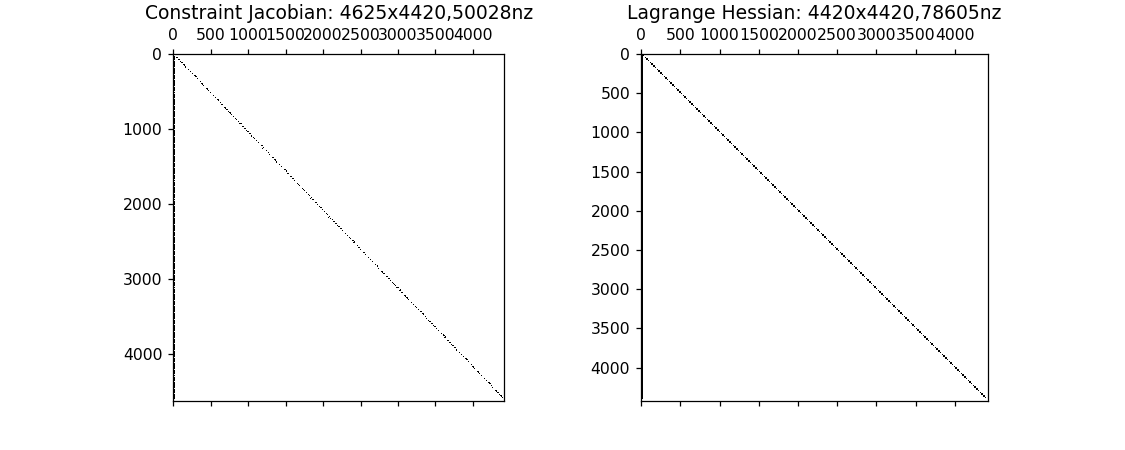

In [41]:
%matplotlib notebook

ocp.spy()

In [12]:
tsa, qa = sol.sample(q, grid='control')
# tsb, x1b = sol.sample(x1, grid='integrator')
# tsc, x1c = sol.sample(x1, grid='integrator', refine=100)
# plot(tsa, x1a, '-')
# plot(tsb, x1b, 'o')
# plot(tsc, x1c, '.')
qa # -4.34362998e-02, -5.85582404e-01, -7.53971357e-01, -2.94505902e-01

array([[ 1.00000000e+00, -6.32158792e-10, -4.50528490e-09,
        -1.54419712e-09],
       [ 9.99999995e-01, -5.66114113e-05, -5.68655177e-05,
        -5.53618998e-05],
       [ 9.99999926e-01, -2.25625033e-04, -2.26597287e-04,
        -2.22093295e-04],
       [ 9.99999624e-01, -5.06513915e-04, -5.08824667e-04,
        -4.99822380e-04],
       [ 9.99998868e-01, -8.36472848e-04, -9.03135411e-04,
        -8.88216190e-04],
       [ 9.99997499e-01, -1.10322642e-03, -1.40904000e-03,
        -1.38702220e-03],
       [ 9.99995309e-01, -1.26141770e-03, -2.02605326e-03,
        -1.99598477e-03],
       [ 9.99991945e-01, -1.31335861e-03, -2.75372719e-03,
        -2.71481156e-03],
       [ 9.99986949e-01, -1.25629950e-03, -3.59160573e-03,
        -3.54321880e-03],
       [ 9.99979753e-01, -1.08965145e-03, -4.53923686e-03,
        -4.48091836e-03],
       [ 9.99969682e-01, -8.13576238e-04, -5.59617096e-03,
        -5.52761870e-03],
       [ 9.99955951e-01, -4.28479496e-04, -6.76195984e-03,
      

<IPython.core.display.Javascript object>


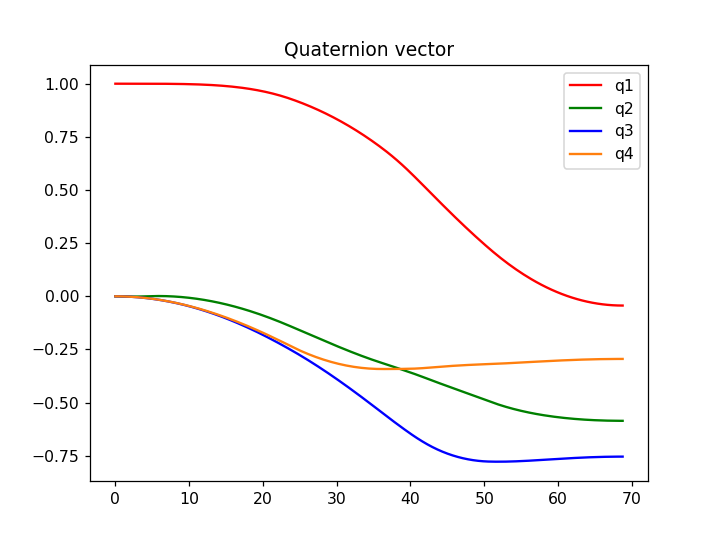

In [13]:
%matplotlib notebook
plt.title('Quaternion vector')
plt.plot(tsa, qa[:,0], 'r', label='q1')
plt.plot(tsa, qa[:,1], 'g', label='q2')
plt.plot(tsa, qa[:,2], 'b', label='q3')
plt.plot(tsa, qa[:,3], 'tab:orange', label='q4')
plt.legend()
plt.show()

In [14]:
tsb, Vb = sol.sample(V, grid='control')

In [15]:
Vb

array([[ 5.98230703,  5.99993493,  5.99962846],
       [ 5.976251  ,  5.99993431,  5.99961887],
       [ 5.96647363,  5.99993368,  5.99960901],
       [-0.6802729 ,  5.99993304,  5.99959888],
       [-5.99019398,  5.99993238,  5.99958847],
       [-5.54635282,  5.9999317 ,  5.99957769],
       [-5.78774305,  5.99993101,  5.99956634],
       [-5.87758336,  5.99993028,  5.9995543 ],
       [-5.88933034,  5.99992954,  5.99954151],
       [-5.89989208,  5.99992876,  5.99952785],
       [-5.88514888,  5.99992796,  5.99951321],
       [-5.77416797,  5.99992713,  5.99949746],
       [ 5.99872657,  5.99992628,  5.99948048],
       [ 5.9991901 ,  5.99992539,  5.99946219],
       [ 5.99456294,  5.99992448,  5.99944257],
       [ 5.98145368,  5.99992354,  5.99942157],
       [ 5.95736937,  5.99992257,  5.99939912],
       [ 5.93581629,  5.99992157,  5.9993751 ],
       [ 5.93022218,  5.99992054,  5.99934938],
       [ 5.94138775,  5.99991949,  5.99932181],
       [ 5.95977979,  5.9999184 ,  5.999

<IPython.core.display.Javascript object>


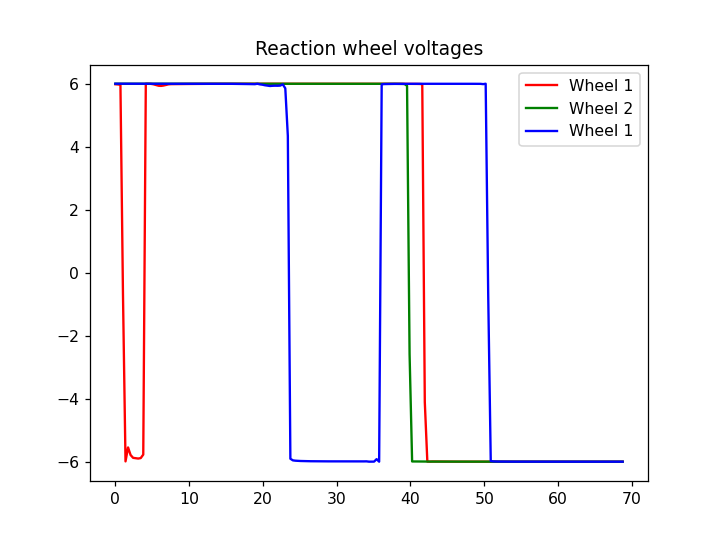

In [17]:
%matplotlib notebook
plt.title("Reaction wheel voltages")
plt.plot(tsb, Vb[:,0], 'r', label="Wheel 1")
plt.plot(tsb, Vb[:,1], 'g', label="Wheel 2")
plt.plot(tsb, Vb[:,2], 'b', label="Wheel 1")
plt.legend()
plt.show()

In [30]:
tsc, wc = sol.sample(w, grid='control')

<IPython.core.display.Javascript object>


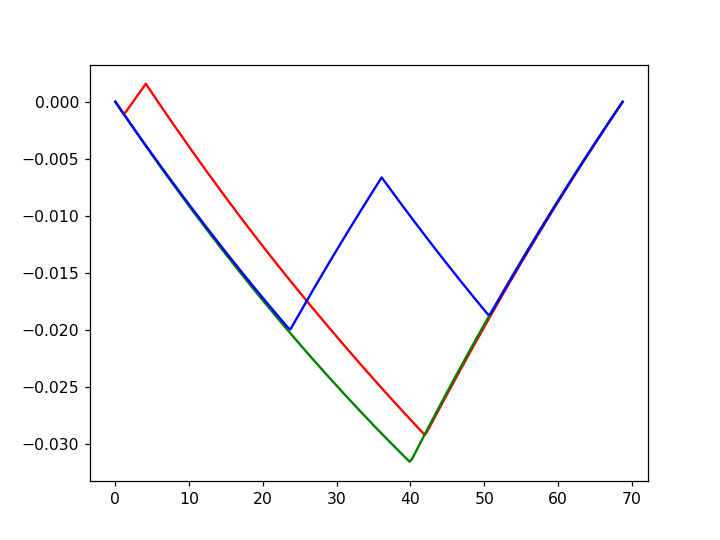

In [31]:
%matplotlib notebook
plt.plot(tsc, wc[:,0], 'r')
plt.plot(tsc, wc[:,1], 'g')
plt.plot(tsc, wc[:,2], 'b')
plt.show()

In [19]:
tsd, Omegad = sol.sample(Omega, grid='control')

<IPython.core.display.Javascript object>


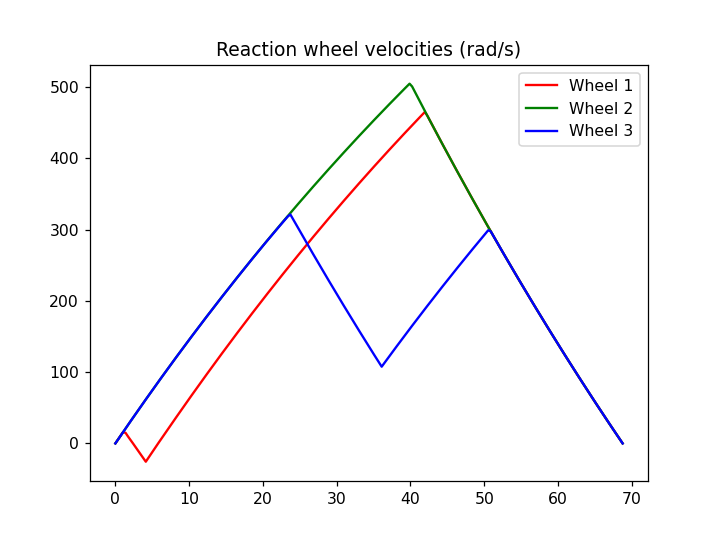

In [22]:
%matplotlib notebook
plt.title("Reaction wheel velocities (rad/s)")
plt.plot(tsd, Omegad[:,0], 'r', label="Wheel 1")
plt.plot(tsd, Omegad[:,1], 'g', label="Wheel 2")
plt.plot(tsd, Omegad[:,2], 'b', label="Wheel 3")
plt.legend()
plt.show()

In [23]:
quat_desired = Quaternion(np.array([-0.0434363, -0.5855824, -0.7539713, -0.2945059]))

In [24]:
err = []
for quat in qa:
    quat_cur = Quaternion(quat)
    err.append(2*np.arccos((quat_cur.conjugate*quat_desired).real)*180/np.pi)

<IPython.core.display.Javascript object>


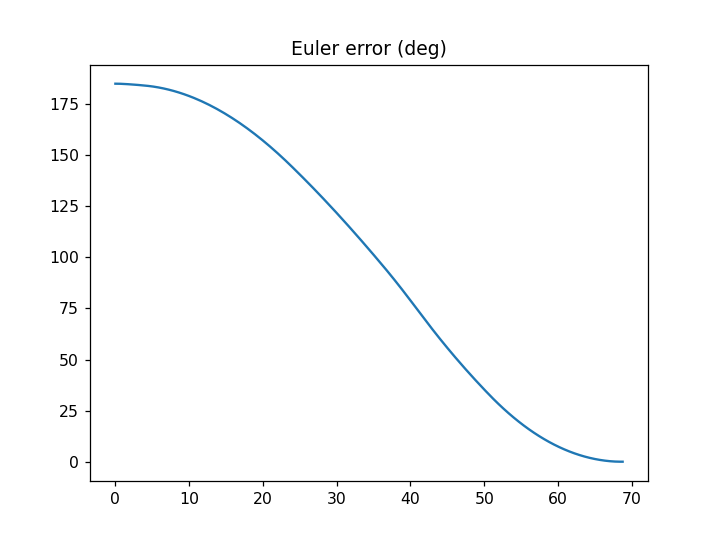

[]

In [25]:
%matplotlib notebook
plt.plot(tsa, err)
plt.title("Euler error (deg)")
plt.plot()

In [61]:
err

[184.97899934537358,
 184.9684095920844,
 184.93674694755052,
 184.88409181385916,
 184.81470933413382,
 184.73619126493472,
 184.65163398374554,
 184.5609295790592,
 184.46430997212062,
 184.3618612182903,
 184.2536183205921,
 184.13959936914162,
 184.0197458279908,
 183.88654508036305,
 183.73258095678676,
 183.55791642248172,
 183.3626224995689,
 183.14678269837043,
 182.9104855353079,
 182.65380773089566,
 182.37680501648165,
 182.07951762496398,
 181.76197984175514,
 181.42423433704093,
 181.0663366408639,
 180.68834539885762,
 180.29031923825528,
 179.87231666665411,
 179.43439592943577,
 178.97661531852734,
 178.4990334031959,
 178.0017091211864,
 177.4847017984055,
 176.94807114904137,
 176.39187727173143,
 175.81618064844764,
 175.22104214740975,
 174.60652303009041,
 173.97268496150824,
 173.31959002355796,
 172.6473007313997,
 171.95588005175082,
 171.24539142367348,
 170.5158987829724,
 169.76746658553688,
 169.0001598345412,
 168.21404411489763,
 167.4091856271246,
 166.58